In [107]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Loading Data

In [18]:
data = dict()
data["fake"]  = pd.read_csv("DATASET/fusers.csv")
data["legit"] = pd.read_csv("DATASET/users.csv")

# Removing unnecessary columns

In [19]:
data["legit"] = data["legit"].drop(["id", "name", "screen_name", "created_at", "lang", "location", "default_profile", "default_profile_image", "geo_enabled", "profile_image_url", "profile_banner_url", "profile_use_background_image", "profile_background_image_url_https", "profile_text_color", "profile_image_url_https", "profile_sidebar_border_color", "profile_background_tile", "profile_sidebar_fill_color", "profile_background_image_url", "profile_background_color", "profile_link_color", "utc_offset", "protected", "verified", "dataset", "updated", "description"], axis=1)
data["fake"]  = data["fake"].drop(["id", "name", "screen_name", "created_at", "lang", "location", "default_profile", "default_profile_image", "geo_enabled", "profile_image_url", "profile_banner_url", "profile_use_background_image", "profile_background_image_url_https", "profile_text_color", "profile_image_url_https", "profile_sidebar_border_color", "profile_background_tile", "profile_sidebar_fill_color", "profile_background_image_url", "profile_background_color", "profile_link_color", "utc_offset", "protected", "verified", "dataset", "updated", "description"], axis=1)

In [20]:
print("Final Available Columns")
data["legit"].columns

Final Available Columns


Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'url', 'time_zone'],
      dtype='object')

# Converting DataFrame to Numpy Array

In [21]:
data["legit"] = data["legit"].values
data["fake"] = data["fake"].values

# Checking Availability of `URL` and `Time Zone`

In [23]:
for i in range(len(data["legit"])):
    if type(data["legit"][i][5]) == str:
        data["legit"][i][5] = 1
    
    if type(data["legit"][i][6]) == str:
        data["legit"][i][6] = 1
        
for i in range(len(data["fake"])):
    if type(data["fake"][i][5]) == str:
        data["fake"][i][5] = 1
    
    if type(data["fake"][i][6]) == str:
        data["fake"][i][6] = 1

# Changing DataType of data to `float64`

In [28]:
data["legit"] = data["legit"].astype(np.float64)
data["fake"] = data["fake"].astype(np.float64)

# Changing all `NaN` to `0`

In [29]:
where_nans = np.isnan(data["legit"])
data["legit"][where_nans] = 0

where_nans = np.isnan(data["fake"])
data["fake"][where_nans] = 0

# Creating merged dataset from legit and fake profile dataset.

In [30]:
X = np.zeros((len(data["fake"]) + len(data["legit"]), 7))
Y = np.zeros(len(data["fake"]) + len(data["legit"]))

In [76]:
for i in range(len(data["legit"])):
    X[i] = data["legit"][i]/max(data["legit"][i])
    Y[i] = -1

for i in range(len(data["fake"])):
    bound = max(data["fake"][i])
    if bound == 0:
        bound = 1
    
    X[len(data["legit"])+i] = data["fake"][i]/bound # Normalizing Data [0 <--> 1]
    Y[len(data["legit"])+i] = 1

# Splitting Dataset into Train and Test

In [32]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, 
    test_size=0.24, random_state=42)

# Loading Deep Learning libraries

In [110]:
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping, Callback

from IPython.display import clear_output

## Initializing Early Stopping Callback to prevent training proceed to overfitting.

In [108]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Creating Accuracy Loss Graph callback

In [111]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []
        

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('Log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
        
plot = PlotLearning()

##  Building Predictive Model

In [112]:
model = Sequential([
    BatchNormalization(),
    
    Dense(16, activation="relu", kernel_regularizer="l2"),
    BatchNormalization(),
    Dense(8, activation="relu", kernel_regularizer="l2"),
    BatchNormalization(),
    Dense(1, activation="tanh"),
])

model.build((None, X.shape[1]))
model.summary()
model.compile(
    optimizer="adadelta",
    loss="binary_crossentropy",
    metrics=["acc"]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_29 (Batc (None, 7)                 28        
_________________________________________________________________
dense_37 (Dense)             (None, 16)                128       
_________________________________________________________________
batch_normalization_30 (Batc (None, 16)                64        
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 136       
_________________________________________________________________
batch_normalization_31 (Batc (None, 8)                 32        
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 9         
Total params: 397
Trainable params: 335
Non-trainable params: 62
_________________________________________________________________


# Iterative Training Process Begins...

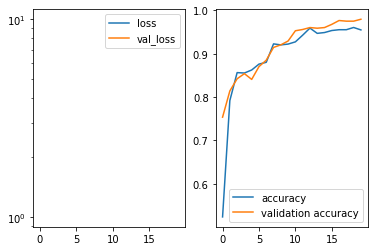

In [113]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), shuffle=True, batch_size=100, callbacks=[early_stopping, plot])

In [114]:
logits = model.predict(X_test).T[0]

In [115]:
for i in range(len(logits)):
    logits[i] = -1 if logits[i] < 0 else 1

In [116]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, title='CONFUSION MATRIX', cmap=plt.cm.Reds):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [117]:
mat = confusion_matrix(y_test, logits)
print(mat)

[[357   1]
 [  3 316]]


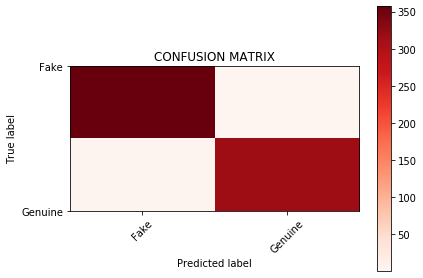

In [118]:
plot_confusion_matrix(mat)

# Validation Accuracy

In [119]:
_, train_acc = model.evaluate(X_train, y_train)
_, val_acc = model.evaluate(X_test, y_test)
print("Train Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)

677/677 [==============================] - 0s 126us/step
Train Accuracy: 0.9822512841959636
Validation Accuracy: 0.9793205317577548
